In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import bin2cell as b2c

#create directory for stardist input/output files
os.makedirs("stardist", exist_ok=True)

# Read in data

In [2]:
adata = sc.read_h5ad('/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/HEA_FOET14880396_b2c.h5ad')
adata

AnnData object with n_obs × n_vars = 5001851 × 18051
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he_0p01', 'labels_he_0p03', 'labels_he_0p05', 'labels_he_0p1', 'labels_he_default', 'labels_he_sel', 'labels_he_expanded_1', 'labels_he_expanded_2', 'labels_he_expanded_3', 'labels_he_expanded_4', 'labels_he_expanded_sel'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [ ]:
# to re-start gex segmentation
# not required if initial attemp
# adata.obs.drop(columns=['labels_gex_0p002', 'labels_gex_0p01', 'labels_gex_0p05', 'labels_gex_sel'],inplace=True)

# Cell detection using gene expression data

The H&E segmentation is not guaranteed to be perfect. There may be some regions that have expression data but lack a visible nuclei to seed a cell. Alternately, nuclei may take on unusual shapes and not be detected by the model. Performing segmentation on a representation of total expression per bin may be able to detect some of the missed cells. However, this kind of segmentation only performs well on sparse tissue, and struggles to differentiate individual cells in dense regions. As such, we use it as secondary means of object identification, preferring H&E where able.

The input image is going to be a representation of the total counts per bin, with a Gaussian filter with a sigma of 5 (measured in pixels) applied for a little smoothing.

In [3]:
%%time
mpp = 0.3
b2c.grid_image(adata, "n_counts_adjusted", mpp=mpp, sigma=5, save_path="stardist/gex.tiff")

CPU times: user 34.7 s, sys: 14 s, total: 48.7 s
Wall time: 1min 10s


The segmentation is performed via StarDist's fluorescence model, and identifies cells rather than nuclei, meaning subsequent label expasion is not necessary. Just like with the H&E model, lowering prob_thresh to make the calls less stringent is recommended. Increasing nms_thresh requires more of the putative objects to be overlapping for them to be merged into a single label, which may help a bit in denser regions.

In [4]:
%%time
prob_thresh_dict = {
    '0p005':0.005,
    '0p01':0.01,
     '0p03':0.03,
    '0p05':0.05,
}

for key,prob_thresh in prob_thresh_dict.items():
    print(f'### {key} ###')
    b2c.stardist(image_path="stardist/gex.tiff", 
                 labels_npz_path=f"stardist/gex_prob{key}.npz", 
                 stardist_model="2D_versatile_fluo", 
                 prob_thresh=prob_thresh, 
                 nms_thresh=0.5
                )
    print('')

### 0p005 ###


2024-12-05 17:50:10.809546: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 17:50:11.174332: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 17:50:11.723242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733421011.999613  690313 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733421012.075924  690313 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 17:50:12.987381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Found model '2D_versatile_fluo' for 'StarDist2D'.


2024-12-05 17:51:24.727765: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  0%|          | 0/36 [00:00<?, ?it/s]functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, None, None, 1))
100%|██████████| 36/36 [49:28<00:00, 82.46s/it]  


Found 155283 objects

### 0p01 ###
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 36/36 [50:34<00:00, 84.30s/it] 


Found 123972 objects

### 0p03 ###
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 36/36 [43:22<00:00, 72.29s/it]


Found 83831 objects

### 0p05 ###
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 36/36 [42:00<00:00, 70.02s/it] 


Found 69281 objects

CPU times: user 1h 56min 24s, sys: 25min 44s, total: 2h 22min 8s
Wall time: 3h 9min 6s


The resulting calls are loaded like the H&E ones were, except the input image was based on array rather than spatial coordinates.

In [5]:
prob_thresh_dict = {
    '0p005':0.005,
    '0p01':0.01,
     '0p03':0.03,
    '0p05':0.05,
}

for key,prob_thresh in prob_thresh_dict.items():
    print(f'### {key} ###')
    b2c.insert_labels(adata, 
                  labels_npz_path=f"stardist/gex_prob{key}.npz", 
                  basis="array", 
                  mpp=mpp, 
                  labels_key=f"labels_gex_{key}"
                 )

### 0p005 ###
### 0p01 ###
### 0p03 ###
### 0p05 ###


We can visualise the cells identified in the GEX space segmentation in our previously defined region.

2949655472.py (11): Trying to modify attribute `.obs` of view, initializing view as actual.


63


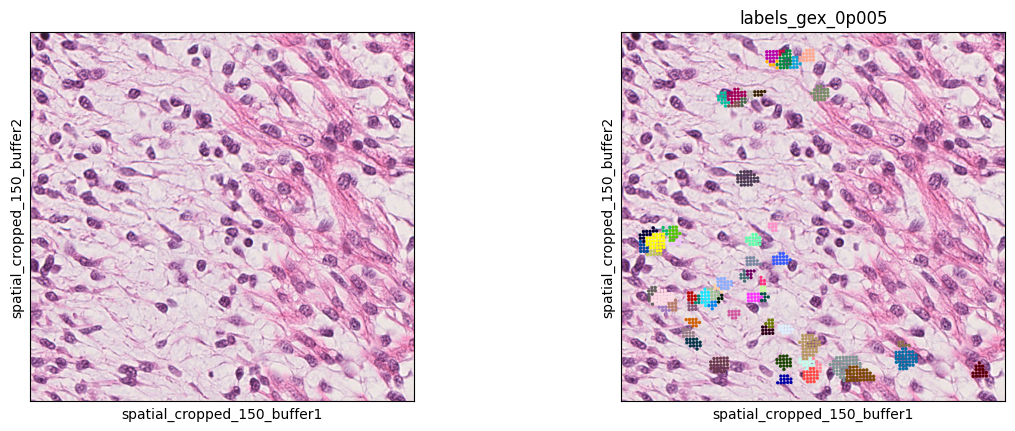

2949655472.py (11): Trying to modify attribute `.obs` of view, initializing view as actual.


47


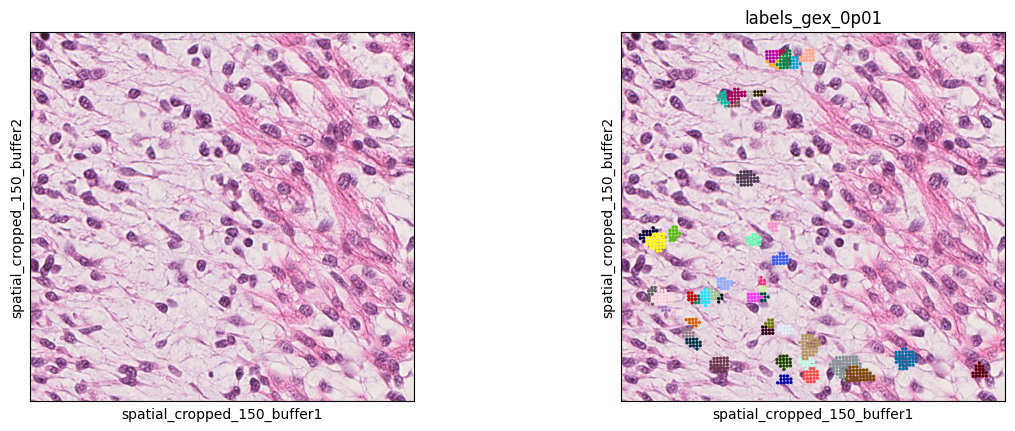

2949655472.py (11): Trying to modify attribute `.obs` of view, initializing view as actual.


30


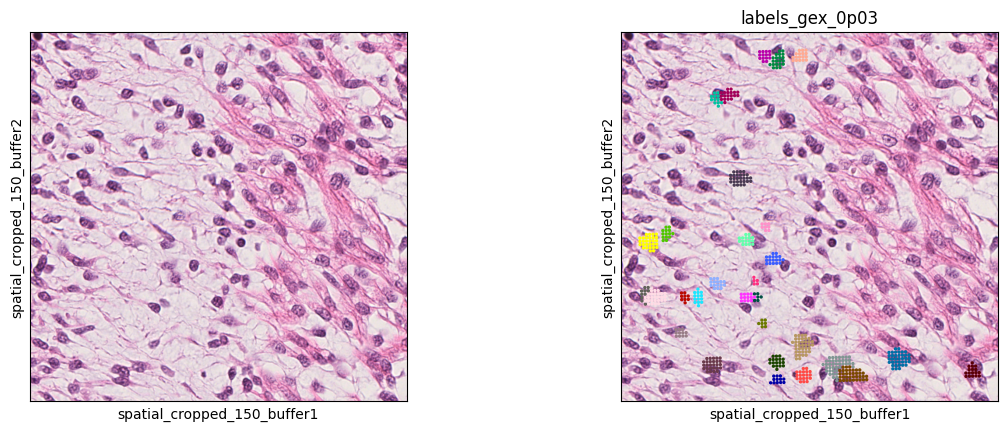

2949655472.py (11): Trying to modify attribute `.obs` of view, initializing view as actual.


26


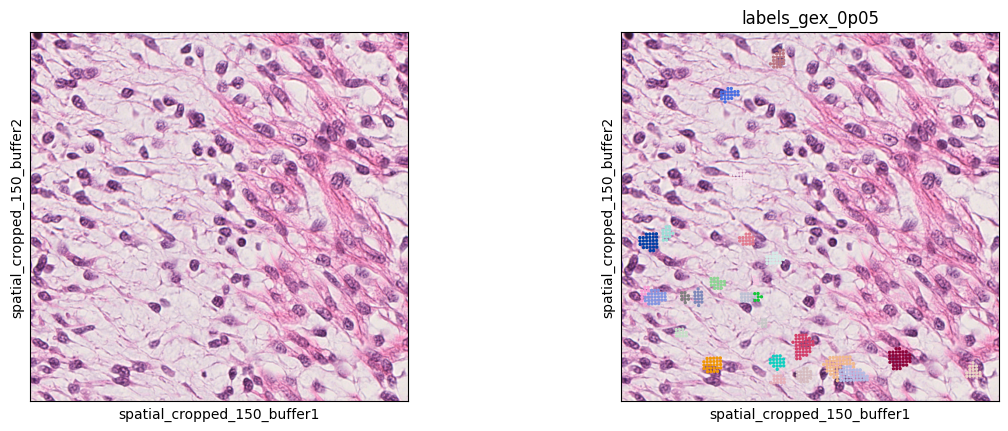

In [7]:
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 1400) & 
        (adata.obs['array_col'] <= 1600)
       )
bdata = adata[mask]

for key in prob_thresh_dict.keys():
    #0 means unassigned
    bdata = bdata[bdata.obs[f"labels_gex_{key}"]>0]
    bdata.obs[f"labels_gex_{key}"] = bdata.obs[f"labels_gex_{key}"].astype(str)
    print(len(set(bdata.obs[f"labels_gex_{key}"])))
    sc.pl.spatial(bdata, color=[None, f"labels_gex_{key}"], img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer",
                  legend_loc=None,ncols=2
                 )

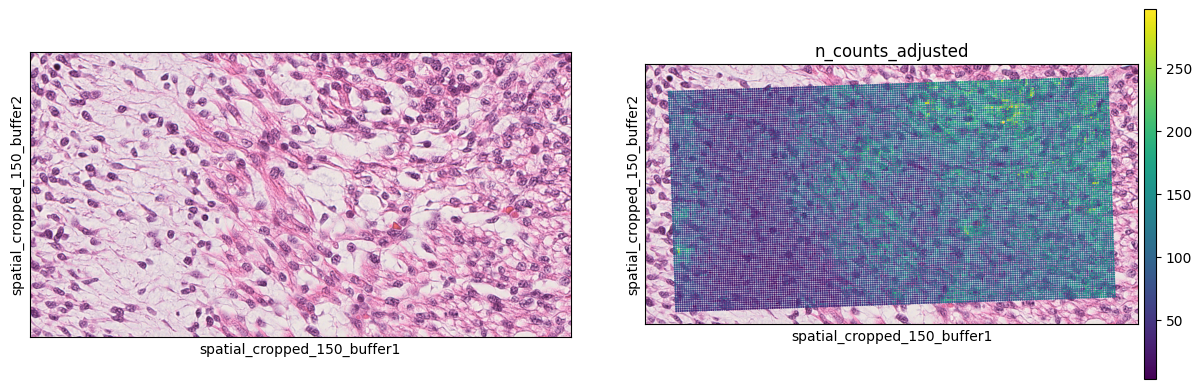

In [8]:
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 1400) & 
        (adata.obs['array_col'] <= 1600)
       )
bdata = adata[mask]
sc.pl.spatial(bdata, color=[None, 'n_counts_adjusted'], img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer",
                  legend_loc=None,ncols=2
                 )

Text(0.5, 1.0, 'sigma: 5, gex_prob_thresh: 0p005')

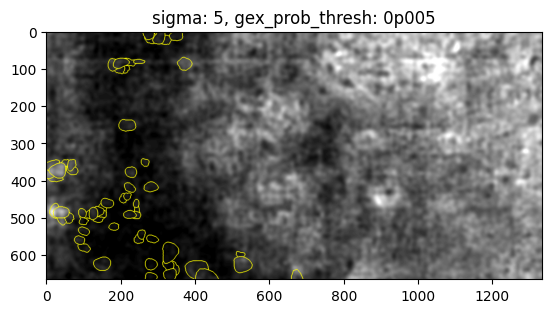

In [9]:
#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="array", mpp=mpp)

#GEX pops better with percentile normalisation performed
rendered = b2c.view_labels(image_path="stardist/gex.tiff", 
                           labels_npz_path="stardist/gex_prob0p005.npz", 
                           crop=crop,
                           stardist_normalize=True
                          )
plt.imshow(rendered)
plt.title('sigma: 5, gex_prob_thresh: 0p005')

Text(0.5, 1.0, 'sigma: 5, gex_prob_thresh: 0p05')

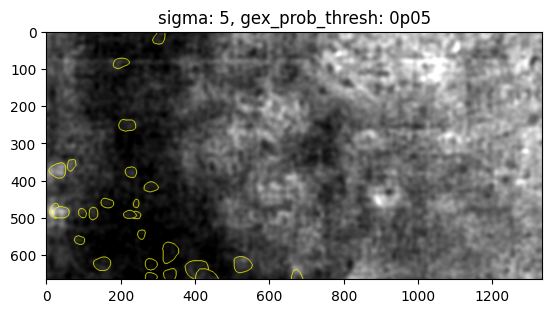

In [10]:
#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="array", mpp=mpp)

#GEX pops better with percentile normalisation performed
rendered = b2c.view_labels(image_path="stardist/gex.tiff", 
                           labels_npz_path="stardist/gex_prob0p05.npz", 
                           crop=crop,
                           stardist_normalize=True
                          )
plt.imshow(rendered)
plt.title('sigma: 5, gex_prob_thresh: 0p05')

In [11]:
gex_prob_thresh_sel = '0p05' # sigma: 5
adata.obs['labels_gex_sel'] = adata.obs[f'labels_gex_{gex_prob_thresh_sel}']

In [12]:
# save
adata.write('/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/HEA_FOET14880396_b2c.h5ad')

In [13]:
adata

AnnData object with n_obs × n_vars = 5001851 × 18051
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he_0p01', 'labels_he_0p03', 'labels_he_0p05', 'labels_he_0p1', 'labels_he_default', 'labels_he_sel', 'labels_he_expanded_1', 'labels_he_expanded_2', 'labels_he_expanded_3', 'labels_he_expanded_4', 'labels_he_expanded_sel', 'labels_gex_0p005', 'labels_gex_0p01', 'labels_gex_0p03', 'labels_gex_0p05', 'labels_gex_sel'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

# Joint HE and GEX labels

In [2]:
# read in
mpp=0.3
adata = sc.read_h5ad('/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/HEA_FOET14880396_b2c.h5ad')
adata

AnnData object with n_obs × n_vars = 5001851 × 18051
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he_0p01', 'labels_he_0p03', 'labels_he_0p05', 'labels_he_0p1', 'labels_he_default', 'labels_he_sel', 'labels_he_expanded_1', 'labels_he_expanded_2', 'labels_he_expanded_3', 'labels_he_expanded_4', 'labels_he_expanded_sel', 'labels_gex_0p005', 'labels_gex_0p01', 'labels_gex_0p03', 'labels_gex_0p05', 'labels_gex_sel'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

Armed with both the H&E and gene expression segmentation results, we can now fill in the gaps in the H&E with GEX calls. We only add GEX cells that do not overlap with any H&E labels.

In [3]:
b2c.salvage_secondary_labels(adata, 
                             primary_label="labels_he_expanded_sel", 
                             secondary_label="labels_gex_sel", 
                             labels_key="labels_joint"
                            )

Salvaged 10198 secondary labels


A few extra GEX-derived cells show up in our test region. Note the presence of .obs["labels_joint_source"] which specifies whether any given label came from the primary or secondary labelling.

2034932217.py (10): Trying to modify attribute `.obs` of view, initializing view as actual.


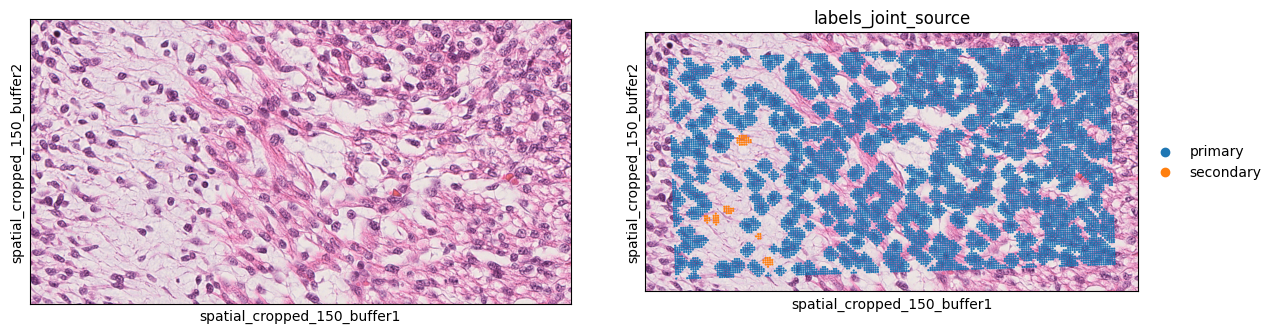

In [4]:
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 1400) & 
        (adata.obs['array_col'] <= 1600)
       )
bdata = adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_joint']>0]
bdata.obs['labels_joint'] = bdata.obs['labels_joint'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_joint_source"],
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")

# ~Remove too small cells~

<Axes: xlabel='count', ylabel='Count'>

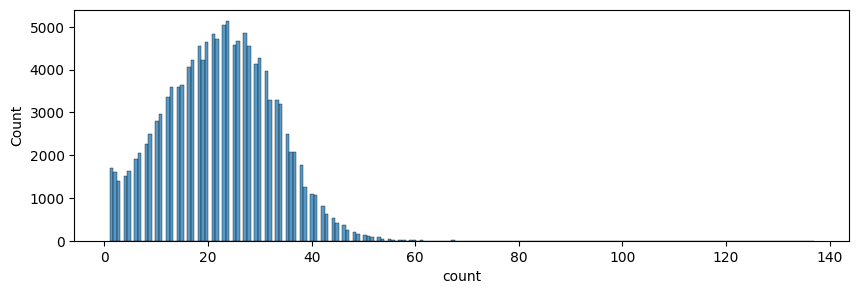

In [5]:
#0 means unassigned
adata_assigned = adata[adata.obs['labels_joint']>0]
counts = adata_assigned.obs['labels_joint'].value_counts()
plt.figure(figsize=(10, 3))
sns.histplot(counts, kde=False, bins=200)

<Axes: xlabel='count', ylabel='Count'>

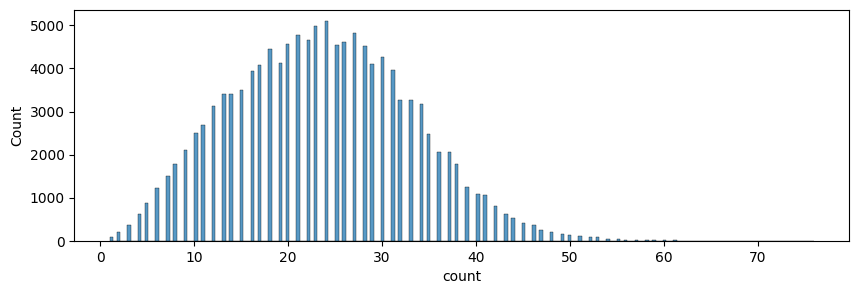

In [6]:
counts_1st = adata_assigned[adata_assigned.obs['labels_joint_source']=='primary'].obs['labels_joint'].value_counts()
plt.figure(figsize=(10, 3))
sns.histplot(counts_1st, kde=False, bins=200)

<Axes: xlabel='count', ylabel='Count'>

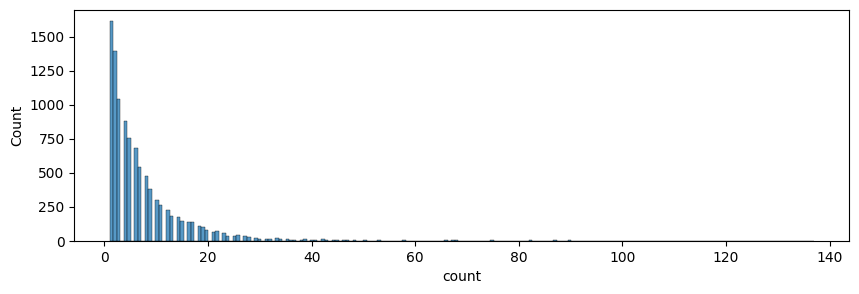

In [7]:
counts_2nd = adata_assigned[adata_assigned.obs['labels_joint_source']=='secondary'].obs['labels_joint'].value_counts()
plt.figure(figsize=(10, 3))
sns.histplot(counts_2nd, kde=False, bins=200)

In [ ]:
'''
# remove
bin_counts_thresh = 5
labels_to_remove = counts.index[counts<bin_counts_thresh]
mask = adata.obs['labels_joint'].isin(labels_to_remove)
bins_to_remove = adata.obs_names[mask]
adata.obs.loc[bins_to_remove,'labels_joint'] = 0

adata_assigned = adata[adata.obs['labels_joint']>0]
counts = adata_assigned.obs['labels_joint'].value_counts()
plt.figure(figsize=(10, 3))
sns.histplot(counts, kde=False, bins=200)
'''

In [ ]:
'''
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 1400) & 
        (adata.obs['array_col'] <= 1600)
       )
bdata = adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_joint']>0]
bdata.obs['labels_joint'] = bdata.obs['labels_joint'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_joint_source"], img_key="0.3_mpp", basis="spatial_cropped")
'''

In [8]:
# save adata
adata.write('/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/HEA_FOET14880396_b2c.h5ad')
adata

AnnData object with n_obs × n_vars = 5001851 × 18051
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he_0p01', 'labels_he_0p03', 'labels_he_0p05', 'labels_he_0p1', 'labels_he_default', 'labels_he_sel', 'labels_he_expanded_1', 'labels_he_expanded_2', 'labels_he_expanded_3', 'labels_he_expanded_4', 'labels_he_expanded_sel', 'labels_gex_0p005', 'labels_gex_0p01', 'labels_gex_0p03', 'labels_gex_0p05', 'labels_gex_sel', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

# Group bins into cells!

At this point, the counts have been destriped and bins have been assigned to cells based on both H&E and GEX segmentation. Time to group the bins into cells!

In [19]:
cdata = b2c.bin_to_cell(adata, labels_key="labels_joint", spatial_keys=["spatial", "spatial_cropped_150_buffer"])
cdata

AnnData object with n_obs × n_vars = 134590 × 18051
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

The object features the sum of gene expression of the constituent bins, and means of the array and spatial coordinates to represent the cell centroids. .obs["labels_joint_source"] is taken as well, providing information on which segmentation any given cell stems from. Let's visualise our test fragment of the tissue, now in cell space!

anndata.py (1146): Trying to modify attribute `.obs` of view, initializing view as actual.


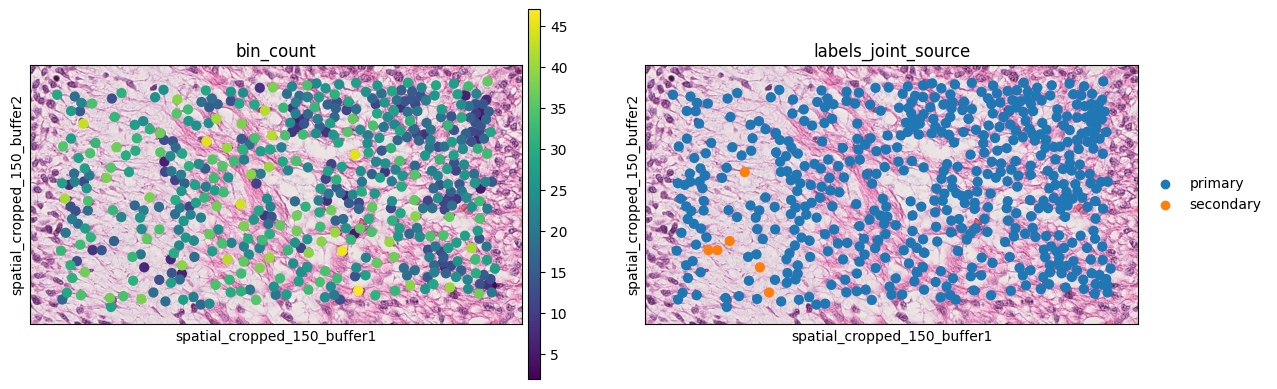

In [20]:
cell_mask = ((cdata.obs['array_row'] >= 1450) & 
        (cdata.obs['array_row'] <= 1550) & 
        (cdata.obs['array_col'] >= 1400) & 
        (cdata.obs['array_col'] <= 1600)
       )
ddata = cdata[cell_mask]
sc.pl.spatial(ddata, color=["bin_count", "labels_joint_source"], 
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer", ncols=2)

# Save

In [21]:
cdata.write('/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/HEA_FOET14880396_b2c_cells.h5ad')

In [22]:
cdata.X.data[:5]

array([0.55027094, 1.30175513, 1.01929175, 1.31881525, 3.24395094])